In [4]:
import newsgroups
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import sklearn.linear_model

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

In [5]:
HEADERS = [
    'From', 'Subject', 'To', 'Reply-To', 'In-Reply-To', 'Apparently-To',
    'Original-Sender', 'Originator', 'Moderator', 'Organization', 'Keywords',
    'Distribution', 'NNTP-Posting-Host', 'Lines', 'Summary', 'Supersedes',
    'X-Bytes', 'X-Disclaimer', 'X-Mailer', 'X-Newsreader', 'X-News-Reader',
    'X-Gated-By', 'X-Added', 'X-Status',
    'OD-Comment-To', 'Expires', 'Disclaimer', 'Article-I.D.', 
    'News-Software',  'Nf-ID', 'Mime-Version'
]

RE_EMAIL = re.compile('<?.*@.*>?', re.M)
RE_LINE_BREAK = re.compile('\\n+', re.M)
RE_CITATION = re.compile('^.*writes:$', re.M)
RE_CITATION_QUOTES = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
RE_HEADERS = re.compile('^(%s):.*$' % '|'.join(HEADERS), re.M|re.I)
def _clean(docs):
    docs = map(rm_headers, docs)
    docs = map(rm_citation, docs)
    docs = map(rm_citation_quotes, docs)
    docs = map(rm_email, docs)
    docs = map(rm_line_break, docs)
    
    return list(docs)

def rm_citation(doc):
    return RE_CITATION.sub('', doc)

def rm_citation_quotes(doc):
    return RE_CITATION_QUOTES.sub(r'\1', doc)

def rm_email(doc):
    return RE_EMAIL.sub('<email>', doc)

def rm_line_break(doc):
    return RE_LINE_BREAK.sub(' ', doc).strip('\n\t ')

def rm_headers(doc):
    return RE_HEADERS.sub('', doc)

In [42]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,num_node=[20,1],accuracy=0.00001,lmbd=0.1,beta=0.5,eps=1e-8):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.num_layer=len(num_node)
        self.num_node=num_node
        self.accuracy=accuracy
        self.lmbd=lmbd
        self.beta=beta;
        self.eps=eps;
        
        self.W=None
        self.b=None
        self.Z=None
        self.A=None
        self.dW=None
        self.db=None
        self.dZ=None
        self.dA=None
        self.SdW=None
        self.Sdb=None
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis = 1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis = 1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis = 0, keepdims = True)
    
    ########################################################################################################################
    
    def __initialize_parameters(self, n_x):
        
        self.W=[]
        self.SdW=[]
        
        self.W.append(list(np.random.randn(self.num_node[0], n_x)/np.sqrt(n_x)))
        self.b = [np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]
       

        self.W = self.W + [list((np.random.randn(self.num_node[i],self.num_node[i - 1])*
                             np.sqrt(1/(self.num_node[i - 1]+self.num_node[i])))) for i in range(1,self.num_layer)]
        
        self.SdW.append(list(np.zeros((self.num_node[0], n_x))))
        self.SdW = self.SdW + [list(np.zeros((self.num_node[i],self.num_node[i - 1]))) for i in range(1,self.num_layer)]
        self.Sdb = [np.zeros((self.num_node[i], 1)) for i in range(self.num_layer)]


        
        
    # Forward part
    def __forward_propagation(self, X):
        self.Z=[]
        self.A=[]
        self.Z.append(np.dot(self.W[0], X) + self.b[0])
        self.A.append(self.__sigmoid(self.Z[0]))

        for i in range(1,len(self.W)-1):
            self.Z.append(np.dot(self.W[i], self.A[i - 1]) + self.b[i])
            self.A.append(self.__sigmoid(self.Z[i]))
        
        self.Z.append(np.dot(self.W[-1], self.A[-1]) + self.b[-1])
        self.A.append(self.__softmax(self.Z[-1]))
        return self.A[-1]
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis = 1)
    
    def compute_cost(self, A, Y):
        J = - np.mean(Y.T * np.log(A.T + 1e-8))
        return J
    
    def to_classlabel(self, z):
        return z.argmax(axis = 1)
       
        
    # Backward part      
    def __backward_propagation(self, X, Y):
        m = X.shape[1]
        n = X.shape[0]
        W, b,Z, A=self.W,self.b,self.Z,self.A

      
        self.dW,self.db,self.dZ,self.dA=[],[],[],[]
        self.dZ.append(A[-1] - Y)
        self.dW.append(1. / m * np.dot(self.dZ[-1], A[-2].T))
        self.db.append(1. / m * np.sum(self.dZ[-1], axis = 1, keepdims = True))
        self.dA.append(np.dot(np.array(W[-1]).T, self.dZ[-1]))       


            

        for i in range(self.num_layer-1):
            self.dZ.append(np.multiply(self.dA[i], np.multiply(A[self.num_layer-2-i], 1 - A[self.num_layer-2-i])))
            if(self.num_layer - 3 - i >= 0):
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], A[self.num_layer-3-i].T))
            else:
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], X.T))
            self.db.append( 1. / m * np.sum(self.dZ[i+1], axis = 1, keepdims = True))
            self.dA.append(np.dot(np.array(W[self.num_layer-2-i]).T, self.dZ[i+1]))
       
        self.dW.reverse()
        self.db.reverse()
        self.dZ.reverse()
        self.dA.reverse()

    
    def __update_parameters(self,m):
        for i in range(self.num_layer):
            self.SdW[i]=self.beta * np.array(self.SdW[i])+(1-self.beta) * np.power(self.dW[i],2)
            self.Sdb[i]=self.beta * np.array(self.Sdb[i])+(1-self.beta) * np.power(self.db[i],2)
            self.W[i] = self.W[i] - self.learning_rate * self.dW[i]/( np.sqrt(self.SdW[i]) +self.eps)
            self.b[i] = self.b[i] - self.learning_rate * self.db[i]/( np.sqrt(self.Sdb[i]) +self.eps)

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        check = []
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.num_node.append(Y.shape[0])
        self.num_layer = self.num_layer + 1
        self.__initialize_parameters(n_x)
 
        for i in range(self.num_iter):
            A = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            self.__backward_propagation(X, Y)

            self.__update_parameters(m)
        
            check.append(cost)
            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)
        return probs.T
    
    def predict(self, X_vert):
        pp = self.predict_proba(X_vert)
        return np.argmax(pp, axis = 1)
    

# Load and preprocess data

In [7]:
data = newsgroups.load()

In [8]:
data.describe(include='all')

,text,group
count,18846,18846
unique,18750,20
top,,rec.sport.hockey
freq,30,999


In [9]:
data

,text,group
0,morgan and guzman will have era's 1 run higher...,rec.sport.baseball
1,"Well, I just got my Centris 610 yesterday. It...",comp.sys.mac.hardware
2,History and classical methods. Modern methods....,sci.crypt
3,ATTENTION: Mac Quadra owners: Many storage ind...,comp.sys.mac.hardware
4,To show that the examples I and others have pr...,alt.atheism
...,...,...
18841,Why are circuit boards green? The material us...,sci.electronics
18842,bike. Luckily the guy stops a foot behind my ...,rec.motorcycles
18843,We were told that the resolution on the 5FGe c...,comp.sys.mac.hardware
18844,CAD Setup For Sale: G486PLB Local Bus Motherbo...,misc.forsale


# Split all data into train and test set

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.group)

#### Train Set:

In [11]:
train.shape

(15076, 2)

#### Test Set:

In [12]:
test.shape

(3770, 2)

#### Train-Set label distribution:

In [13]:
train.group.value_counts()

rec.sport.hockey            799
soc.religion.christian      798
rec.motorcycles             797
rec.sport.baseball          795
sci.crypt                   793
sci.med                     792
rec.autos                   792
sci.space                   790
comp.windows.x              790
comp.os.ms-windows.misc     788
sci.electronics             787
comp.sys.ibm.pc.hardware    786
misc.forsale                780
comp.graphics               778
comp.sys.mac.hardware       770
talk.politics.mideast       752
talk.politics.guns          728
alt.atheism                 639
talk.politics.misc          620
talk.religion.misc          502
Name: group, dtype: int64

#### Test-Set label distribution

In [14]:
test.group.value_counts()

rec.sport.hockey            200
rec.motorcycles             199
rec.sport.baseball          199
soc.religion.christian      199
comp.windows.x              198
sci.crypt                   198
rec.autos                   198
sci.med                     198
comp.os.ms-windows.misc     197
sci.electronics             197
sci.space                   197
comp.sys.ibm.pc.hardware    196
misc.forsale                195
comp.graphics               195
comp.sys.mac.hardware       193
talk.politics.mideast       188
talk.politics.guns          182
alt.atheism                 160
talk.politics.misc          155
talk.religion.misc          126
Name: group, dtype: int64

# Encode text using bag of words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=20).fit(train.text)

In [17]:
keys = sorted((key, token) for token, key in cv.vocabulary_.items())
keys

[(0, 'and'),
 (1, 'are'),
 (2, 'as'),
 (3, 'ax'),
 (4, 'be'),
 (5, 'email'),
 (6, 'for'),
 (7, 'have'),
 (8, 'in'),
 (9, 'is'),
 (10, 'it'),
 (11, 'not'),
 (12, 'of'),
 (13, 'on'),
 (14, 'that'),
 (15, 'the'),
 (16, 'this'),
 (17, 'to'),
 (18, 'with'),
 (19, 'you')]

In [18]:
samples = ['this is an email', 'be not afraid', 'may force be with you and you']
encoded = pd.DataFrame(data = cv.transform(samples).toarray(), columns = [token for key, token in keys])
encoded

,and,are,as,ax,be,email,for,have,in,is,it,not,of,on,that,the,this,to,with,you
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2


# Encode text using TF-IDF

Consider a document containing 100 words wherein the word ’cat’ appears 3 times. Assume we have 10 million documents and the word ’cat’ appears in one thousand of these. Calculate TF-idf for the term ‘cat’
1. Tf = 3 / 100 = 0.03
2. Idf = log(10000000 / 1000) = 4.0
3. TfIdf = Tf * Idf = 0.03 * 4.0 = 0.12

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20).fit(train.text)

In [20]:
keys = sorted((key, token) for token, key in tfidf.vocabulary_.items())
keys

[(0, 'and'),
 (1, 'are'),
 (2, 'as'),
 (3, 'ax'),
 (4, 'be'),
 (5, 'email'),
 (6, 'for'),
 (7, 'have'),
 (8, 'in'),
 (9, 'is'),
 (10, 'it'),
 (11, 'not'),
 (12, 'of'),
 (13, 'on'),
 (14, 'that'),
 (15, 'the'),
 (16, 'this'),
 (17, 'to'),
 (18, 'with'),
 (19, 'you')]

In [21]:
samples = ['this is an email', 'be not afraid', 'may force be with you and you']
encoded = pd.DataFrame(data = tfidf.transform(samples).toarray(), columns = [token for key, token in keys])
encoded

,and,are,as,ax,be,email,for,have,in,is,it,not,of,on,that,the,this,to,with,you
0,0.000000,0.0,0.0,0.0,0.000000,0.580743,0.0,0.0,0.0,0.525736,0.0,0.000000,0.0,0.0,0.0,0.0,0.621563,0.0,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.696696,0.000000,0.0,0.0,0.0,0.000000,0.0,0.717367,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.297537,0.0,0.0,0.0,0.391901,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.396685,0.774936


#### Vocabulary

In [22]:
tfidf = TfidfVectorizer(max_features=10000).fit(train.text)
len(tfidf.vocabulary_)

10000

#### Encode train and test sets using same vocabulary

In [23]:
X_train = tfidf.transform(train.text).toarray()
print('X_train shape: %s' % (X_train.shape,))

X_test = tfidf.transform(test.text).toarray()
print('X_test shape: %s' % (X_test.shape,))

X_train shape: (15076, 10000)
X_test shape: (3770, 10000)


# Convert labels to integer values

#### Fit label encoder:

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(train.group)

#### Known labels:

In [25]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

#### Convert labels using encoder:

In [26]:
Y_train = label_encoder.transform(train.group)
print('Y_train shape: %s' % (Y_train.shape,))

Y_test = label_encoder.transform(test.group)
print('Y_test shape: %s' % (Y_test.shape,))

Y_train shape: (15076,)
Y_test shape: (3770,)


<h1>Castom Classificator</h1>

In [43]:
clsC = NeuralNet(normalize = True, learning_rate = 0.01, num_iter = 1000,num_node=[60],accuracy=0.00000001,beta=0.8)

In [44]:
encoder = OneHotEncoder()
Y_train_e = encoder.fit_transform(Y_train.reshape((Y_train.shape[0], 1))).toarray()

C:\Users\nasty\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0-th iteration: 0.15829622787383935
100-th iteration: 0.009990790523064114
200-th iteration: 0.005463092860667361
300-th iteration: 0.0042497385884468575
400-th iteration: 0.0034853954732578197
500-th iteration: 0.003134183205038876
600-th iteration: 0.0026464916839642307
700-th iteration: 0.0023870726197341647
800-th iteration: 0.00284483936795149
900-th iteration: 0.0023328835032115354


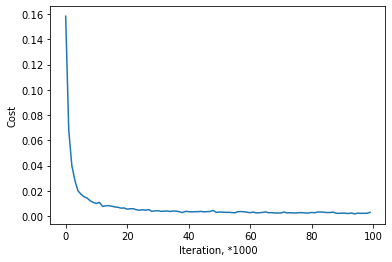

In [45]:
clsC.fit(X_train, Y_train_e)

In [55]:
y_train_pred=clsC.predict(X_train)

In [64]:
accuracy_ts = accuracy_score(Y_train, y_train_pred)
precision_ts = precision_score(Y_train, y_train_pred, average='micro')
recall_ts = recall_score(Y_train, y_train_pred, average='micro')
print('accuracy: ', accuracy_ts)
print('precision: ', precision_ts)
print('recall: ', recall_ts)

accuracy:  0.9868665428495622
precision:  0.9868665428495622
recall:  0.9868665428495622


In [50]:
print(classification_report(Y_train, y_train_pred,target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.94      0.99      0.97       639
           comp.graphics       0.99      0.98      0.98       778
 comp.os.ms-windows.misc       0.97      0.97      0.97       788
comp.sys.ibm.pc.hardware       0.98      0.98      0.98       786
   comp.sys.mac.hardware       0.99      0.98      0.99       770
          comp.windows.x       1.00      0.97      0.98       790
            misc.forsale       0.97      0.97      0.97       780
               rec.autos       0.98      0.99      0.99       792
         rec.motorcycles       1.00      0.99      1.00       797
      rec.sport.baseball       0.99      0.99      0.99       795
        rec.sport.hockey       1.00      0.99      1.00       799
               sci.crypt       1.00      0.99      1.00       793
         sci.electronics       0.99      0.99      0.99       787
                 sci.med       1.00      0.99      1.00       792
         

In [53]:
cm = confusion_matrix(Y_train, y_train_pred) 
print(cm)

[[635   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   0
    1   1]
 [  4 760   7   3   0   1   3   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  5   7 765   5   0   1   0   1   0   0   0   0   1   1   0   0   0   2
    0   0]
 [  3   1   3 767   4   0   6   1   0   0   0   0   0   0   0   0   1   0
    0   0]
 [  3   1   1   2 757   0   3   2   0   0   0   0   0   0   0   0   0   1
    0   0]
 [  5   1   5   0   0 768   0   0   0   0   0   0   2   0   0   0   1   8
    0   0]
 [  5   0   0   0   1   0 758   4   1   1   0   0   5   0   0   0   1   3
    1   0]
 [  2   0   0   0   0   0   0 788   0   0   0   0   1   0   0   0   0   1
    0   0]
 [  1   0   0   0   0   0   0   0 793   1   0   0   0   0   0   0   0   2
    0   0]
 [  2   0   0   0   0   0   0   1   0 789   1   0   1   0   0   0   1   0
    0   0]
 [  0   0   0   0   0   0   0   1   0   2 794   0   0   0   0   1   0   1
    0   0]
 [  0   0   1   0   0   0   0   0   0   0   0 789   0   0   0   0

In [65]:
y_test_pred=clsC.predict(X_test)

In [66]:
accuracy_ts = accuracy_score(Y_test, y_test_pred)
precision_ts = precision_score(Y_test, y_test_pred, average='micro')
recall_ts = recall_score(Y_test, y_test_pred, average='micro')

In [68]:
print('accuracy: ', accuracy_ts)
print('precision: ', precision_ts)
print('recall: ', recall_ts)

accuracy:  0.7973474801061008
precision:  0.7973474801061008
recall:  0.7973474801061008


In [67]:
print(classification_report(Y_test, y_test_pred,target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.76      0.72      0.74       160
           comp.graphics       0.75      0.72      0.74       195
 comp.os.ms-windows.misc       0.69      0.75      0.72       197
comp.sys.ibm.pc.hardware       0.69      0.72      0.71       196
   comp.sys.mac.hardware       0.71      0.79      0.75       193
          comp.windows.x       0.86      0.74      0.80       198
            misc.forsale       0.73      0.74      0.73       195
               rec.autos       0.84      0.80      0.82       198
         rec.motorcycles       0.86      0.86      0.86       199
      rec.sport.baseball       0.87      0.89      0.88       199
        rec.sport.hockey       0.90      0.90      0.90       200
               sci.crypt       0.93      0.85      0.89       198
         sci.electronics       0.69      0.78      0.73       197
                 sci.med       0.87      0.84      0.86       198
         

In [69]:
cm = confusion_matrix(Y_test, y_test_pred)
print(cm)

[[116   1   2   0   2   0   1   0   0   1   0   2   3   2   4   7   2   1
    3  13]
 [  1 141  14   6   6   9   3   2   1   0   0   1   4   2   2   0   1   1
    0   1]
 [  0   8 148  15   7   4   6   0   0   1   0   0   3   2   0   1   0   1
    1   0]
 [  0   3  12 142  16   0   7   2   1   0   0   0   4   0   3   1   2   1
    1   1]
 [  1   3   9  11 153   0   3   2   1   1   0   2   5   0   0   0   0   0
    2   0]
 [  1  15  10   5   5 146   1   2   1   1   3   1   2   3   1   0   0   0
    1   0]
 [  3   4   3  12   7   1 144   6   1   0   1   0   9   0   2   0   1   0
    1   0]
 [  0   0   3   4   2   1   4 159   7   3   1   0   5   1   3   2   1   0
    2   0]
 [  1   0   1   1   1   0   2   7 171   2   2   0   3   2   2   0   3   1
    0   0]
 [  0   0   0   1   0   0   2   1   2 178   5   0   4   0   1   0   2   2
    0   1]
 [  0   0   1   0   2   1   1   1   2   7 179   0   3   0   1   0   0   1
    1   0]
 [  1   4   1   1   1   1   2   1   1   1   0 168   4   1   2   1

<h1>MultinomialNB</h1>

In [47]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, Y_train)

In [48]:
y_test_pred=clf.predict(X_test)
print(classification_report(Y_test, y_test_pred,target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.58      0.67       160
           comp.graphics       0.72      0.79      0.76       195
 comp.os.ms-windows.misc       0.77      0.77      0.77       197
comp.sys.ibm.pc.hardware       0.69      0.79      0.73       196
   comp.sys.mac.hardware       0.85      0.77      0.81       193
          comp.windows.x       0.84      0.82      0.83       198
            misc.forsale       0.89      0.75      0.81       195
               rec.autos       0.87      0.86      0.86       198
         rec.motorcycles       0.88      0.90      0.89       199
      rec.sport.baseball       0.95      0.95      0.95       199
        rec.sport.hockey       0.93      0.93      0.93       200
               sci.crypt       0.85      0.91      0.88       198
         sci.electronics       0.82      0.77      0.79       197
                 sci.med       0.94      0.88      0.91       198
         

In [56]:
y_test_pred=clsC.predict(X_test)

In [58]:
accuracy_ts = accuracy_score(Y_test, y_test_pred)
precision_ts = precision_score(Y_test, y_test_pred, average='micro')
recall_ts = recall_score(Y_test, y_test_pred, average='micro')
print('accuracy: ', accuracy_ts)
print('precision: ', precision_ts)
print('recall: ', recall_ts)

accuracy:  0.7973474801061008
precision:  0.7973474801061008
recall:  0.7973474801061008


In [59]:
print(classification_report(Y_test, y_test_pred,target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.76      0.72      0.74       160
           comp.graphics       0.75      0.72      0.74       195
 comp.os.ms-windows.misc       0.69      0.75      0.72       197
comp.sys.ibm.pc.hardware       0.69      0.72      0.71       196
   comp.sys.mac.hardware       0.71      0.79      0.75       193
          comp.windows.x       0.86      0.74      0.80       198
            misc.forsale       0.73      0.74      0.73       195
               rec.autos       0.84      0.80      0.82       198
         rec.motorcycles       0.86      0.86      0.86       199
      rec.sport.baseball       0.87      0.89      0.88       199
        rec.sport.hockey       0.90      0.90      0.90       200
               sci.crypt       0.93      0.85      0.89       198
         sci.electronics       0.69      0.78      0.73       197
                 sci.med       0.87      0.84      0.86       198
         

In [60]:
cm = confusion_matrix(Y_test, y_test_pred) 
print(cm)

[[116   1   2   0   2   0   1   0   0   1   0   2   3   2   4   7   2   1
    3  13]
 [  1 141  14   6   6   9   3   2   1   0   0   1   4   2   2   0   1   1
    0   1]
 [  0   8 148  15   7   4   6   0   0   1   0   0   3   2   0   1   0   1
    1   0]
 [  0   3  12 142  16   0   7   2   1   0   0   0   4   0   3   1   2   1
    1   1]
 [  1   3   9  11 153   0   3   2   1   1   0   2   5   0   0   0   0   0
    2   0]
 [  1  15  10   5   5 146   1   2   1   1   3   1   2   3   1   0   0   0
    1   0]
 [  3   4   3  12   7   1 144   6   1   0   1   0   9   0   2   0   1   0
    1   0]
 [  0   0   3   4   2   1   4 159   7   3   1   0   5   1   3   2   1   0
    2   0]
 [  1   0   1   1   1   0   2   7 171   2   2   0   3   2   2   0   3   1
    0   0]
 [  0   0   0   1   0   0   2   1   2 178   5   0   4   0   1   0   2   2
    0   1]
 [  0   0   1   0   2   1   1   1   2   7 179   0   3   0   1   0   0   1
    1   0]
 [  1   4   1   1   1   1   2   1   1   1   0 168   4   1   2   1

# Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, Y_train)

#### Train report:

In [28]:
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.88      0.72      0.79       639
           comp.graphics       0.84      0.85      0.85       778
 comp.os.ms-windows.misc       0.83      0.86      0.85       788
comp.sys.ibm.pc.hardware       0.79      0.88      0.83       786
   comp.sys.mac.hardware       0.92      0.89      0.91       770
          comp.windows.x       0.92      0.88      0.90       790
            misc.forsale       0.90      0.80      0.85       780
               rec.autos       0.91      0.94      0.92       792
         rec.motorcycles       0.96      0.95      0.96       797
      rec.sport.baseball       0.96      0.97      0.97       795
        rec.sport.hockey       0.94      0.98      0.96       799
               sci.crypt       0.91      0.95      0.93       793
         sci.electronics       0.88      0.84      0.86       787
                 sci.med       0.94      0.95      0.95       792
         

#### Test report:

In [29]:
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.58      0.67       160
           comp.graphics       0.72      0.79      0.76       195
 comp.os.ms-windows.misc       0.77      0.77      0.77       197
comp.sys.ibm.pc.hardware       0.69      0.79      0.73       196
   comp.sys.mac.hardware       0.85      0.77      0.81       193
          comp.windows.x       0.84      0.82      0.83       198
            misc.forsale       0.89      0.75      0.81       195
               rec.autos       0.87      0.86      0.86       198
         rec.motorcycles       0.88      0.90      0.89       199
      rec.sport.baseball       0.95      0.95      0.95       199
        rec.sport.hockey       0.93      0.93      0.93       200
               sci.crypt       0.85      0.91      0.88       198
         sci.electronics       0.82      0.77      0.79       197
                 sci.med       0.94      0.88      0.91       198
         

In [30]:
from sklearn.metrics import confusion_matrix


cm = pd.DataFrame(data = confusion_matrix(Y_test, clf.predict(X_test)), 
                  index = label_encoder.classes_, 
                  columns= label_encoder.classes_)
cm

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,93,1,0,0,1,0,0,0,2,0,0,0,0,0,0,50,7,6,0,0
comp.graphics,0,155,7,7,2,10,1,1,2,0,2,4,1,1,1,1,0,0,0,0
comp.os.ms-windows.misc,1,9,151,18,2,9,1,1,1,0,0,2,1,0,1,0,0,0,0,0
comp.sys.ibm.pc.hardware,0,5,13,154,9,3,3,1,1,0,1,1,5,0,0,0,0,0,0,0
comp.sys.mac.hardware,0,3,6,18,148,1,2,1,0,1,1,3,8,0,0,1,0,0,0,0
comp.windows.x,0,16,3,7,0,163,0,1,0,0,1,2,1,0,3,1,0,0,0,0
misc.forsale,0,1,1,12,5,1,147,4,6,0,4,5,6,0,2,1,0,0,0,0
rec.autos,0,1,2,1,0,1,3,170,6,1,1,0,2,3,0,4,3,0,0,0
rec.motorcycles,0,3,0,0,0,0,1,7,180,0,0,0,1,0,2,3,2,0,0,0
rec.sport.baseball,0,0,2,0,0,0,1,0,1,190,3,0,0,0,0,0,1,0,1,0


# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, Y_train)

C:\Users\nasty\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nasty\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### Train report:

In [32]:
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.91      0.89      0.90       639
           comp.graphics       0.87      0.91      0.89       778
 comp.os.ms-windows.misc       0.86      0.87      0.86       788
comp.sys.ibm.pc.hardware       0.86      0.85      0.86       786
   comp.sys.mac.hardware       0.94      0.91      0.93       770
          comp.windows.x       0.92      0.90      0.91       790
            misc.forsale       0.82      0.91      0.86       780
               rec.autos       0.93      0.93      0.93       792
         rec.motorcycles       0.97      0.95      0.96       797
      rec.sport.baseball       0.96      0.98      0.97       795
        rec.sport.hockey       0.99      0.98      0.98       799
               sci.crypt       0.97      0.94      0.96       793
         sci.electronics       0.89      0.90      0.90       787
                 sci.med       0.95      0.96      0.96       792
         

#### Test report

In [33]:
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.78      0.74      0.76       160
           comp.graphics       0.75      0.82      0.78       195
 comp.os.ms-windows.misc       0.82      0.81      0.82       197
comp.sys.ibm.pc.hardware       0.78      0.72      0.75       196
   comp.sys.mac.hardware       0.84      0.80      0.82       193
          comp.windows.x       0.84      0.85      0.85       198
            misc.forsale       0.76      0.86      0.80       195
               rec.autos       0.84      0.85      0.84       198
         rec.motorcycles       0.90      0.90      0.90       199
      rec.sport.baseball       0.91      0.95      0.93       199
        rec.sport.hockey       0.98      0.90      0.94       200
               sci.crypt       0.94      0.89      0.92       198
         sci.electronics       0.81      0.83      0.82       197
                 sci.med       0.88      0.88      0.88       198
         

# Support Vector Machines

https://en.wikipedia.org/wiki/Support-vector_machine#Linear_SVM

#### Hard margin

![image.png](images/svm.png)

$$ \huge \overrightarrow{w} \cdot \overrightarrow{x} - b = 1;$$
$$ \huge \overrightarrow{w} \cdot \overrightarrow{x} - b = -1;$$
$$ \huge distance = \frac{2}{||\overrightarrow{w}||};$$
$$ \huge y_i(\overrightarrow{w} \cdot \overrightarrow{x_i} - b) \geq 1, \forall i;$$

#### Soft margin

![image.png](images/svm_2.png)

$$ \huge hinge = max(0, 1 - y_i(\overrightarrow{w} \cdot \overrightarrow{x_i} - b));$$
$$ \huge loss = \frac{1}{n} \sum_{i=1}^{n} hinge + \lambda ||\overrightarrow{w}||^2;$$
$$ \huge loss = \frac{1}{n} \sum_{i=1}^{n} max(0, 1 - y_i(\overrightarrow{w} \cdot \overrightarrow{x_i} - b)) + \lambda ||\overrightarrow{w}||^2;$$

In [34]:
from sklearn.svm import LinearSVC

clf = LinearSVC().fit(X_train, Y_train)

#### Train report:

In [35]:
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.99      0.99       639
           comp.graphics       0.99      0.99      0.99       778
 comp.os.ms-windows.misc       0.98      0.98      0.98       788
comp.sys.ibm.pc.hardware       0.98      0.97      0.98       786
   comp.sys.mac.hardware       1.00      0.99      0.99       770
          comp.windows.x       0.99      0.99      0.99       790
            misc.forsale       0.95      0.99      0.97       780
               rec.autos       1.00      0.99      1.00       792
         rec.motorcycles       1.00      1.00      1.00       797
      rec.sport.baseball       1.00      1.00      1.00       795
        rec.sport.hockey       1.00      1.00      1.00       799
               sci.crypt       1.00      1.00      1.00       793
         sci.electronics       1.00      0.99      0.99       787
                 sci.med       1.00      0.99      1.00       792
         

#### Test report:

In [36]:
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.81      0.82       160
           comp.graphics       0.81      0.86      0.83       195
 comp.os.ms-windows.misc       0.81      0.85      0.83       197
comp.sys.ibm.pc.hardware       0.81      0.77      0.79       196
   comp.sys.mac.hardware       0.85      0.82      0.84       193
          comp.windows.x       0.86      0.86      0.86       198
            misc.forsale       0.80      0.88      0.84       195
               rec.autos       0.88      0.88      0.88       198
         rec.motorcycles       0.93      0.91      0.92       199
      rec.sport.baseball       0.95      0.95      0.95       199
        rec.sport.hockey       0.97      0.93      0.95       200
               sci.crypt       0.97      0.92      0.94       198
         sci.electronics       0.86      0.83      0.85       197
                 sci.med       0.91      0.90      0.91       198
         

In [37]:
import pickle

with open('svc.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [38]:
with open('svc.pkl', 'rb') as f:
    new_clf = pickle.load(f)
    x = tfidf.transform(['I hate photoshop'])
    y_encoded = new_clf.predict(x)
    y_labeled = label_encoder.inverse_transform(y_encoded) 
    print(y_labeled)

['comp.graphics']


Further reading https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html